In [1]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

df = pd.read_csv('/Users/varnika/Desktop/harvard/all_var_int.csv')
pd.set_option('display.max_columns', None)

/Users/varnika/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/var/folders/gw/xg9wcgln7x1f2k7qpz6vkm_c0000gn/T/ipykernel_36172/1522025319.py:7: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/varnika/Desktop/harvard/all_var_int.csv')


In [6]:
heatwave_adaptive_vars = [
    # Electricity & Infrastructure
    "vill_elec_no_ratio",     # fraction of villages with no electricity (inverse)
    "vill_elec_mt_12_ratio",  # fraction with >12 hrs electricity/day (positive)
    "vill_road_coverage",     # fraction of villages connected by all-weather roads
    "vill_rwh_coverage",      # fraction with rainwater-harvesting systems
    "road_pop_coverage",      # proportion of population with reliable road access
    
    # Financial / Institutional
    "bc_per_10k_pop",         # bank correspondents per 10k people
    "branch_per_10k_pop",     # bank branches per 10k people
    "shg_per_1000_hh",        # SHGs per 1000 households
    "pmuy_ratio",             # coverage of LPG (clean cooking fuel)
    "loan_per_hh",            # average credit access per household (if available)
    
    # Social Safety Nets & Livelihood
    "jobcard_issued_ratio",   # fraction of households with MGNREGA jobcards
    "active_jobcard_ratio",   # fraction of jobcards actively used
    "hh_non_farm_ratio",      # non-farm livelihood diversification
    
    # Water & Irrigation
    "irrigation_ratio",       # fraction of net irrigated area (crops less vulnerable to heat)      
]


In [7]:
import pandas as pd

id_cols = ["state_code", "district_code", "block_code", "FID_Key"]
heatwave_cols = id_cols + heatwave_adaptive_vars

heatwave_acap_df = df[heatwave_cols].copy()
print(heatwave_acap_df.isna().sum())  # see if any col has many missing values


state_code               0
district_code            0
block_code               0
FID_Key                  0
vill_elec_no_ratio       0
vill_elec_mt_12_ratio    0
vill_road_coverage       0
vill_rwh_coverage        0
road_pop_coverage        0
bc_per_10k_pop           0
branch_per_10k_pop       0
shg_per_1000_hh          0
pmuy_ratio               0
loan_per_hh              0
jobcard_issued_ratio     0
active_jobcard_ratio     0
hh_non_farm_ratio        0
irrigation_ratio         0
dtype: int64


In [8]:
from sklearn.preprocessing import RobustScaler

Rscaler = RobustScaler()

# Scale only the chosen adaptive columns
features_only = heatwave_acap_df[heatwave_adaptive_vars].astype(float).values
features_scaled = Rscaler.fit_transform(features_only)

# Create a scaled DataFrame
acap_scaled = pd.DataFrame(features_scaled, 
                           columns=heatwave_adaptive_vars, 
                           index=heatwave_acap_df.index)

# Attach scaled columns back
for col in heatwave_adaptive_vars:
    heatwave_acap_df[col + "_scaled"] = acap_scaled[col]

In [9]:
from sklearn.decomposition import PCA
import numpy as np

# Collect only scaled columns
acap_pca_vars = [c for c in heatwave_acap_df.columns if c.endswith("_scaled")]
X_acap = heatwave_acap_df[acap_pca_vars].astype(float)

pca = PCA()
pca.fit(X_acap)

# Summarize variance
pcaSummary_heat = pd.DataFrame({
    '% variance': pca.explained_variance_ratio_,
    'Cumulative %': np.cumsum(pca.explained_variance_ratio_)
})
print(pcaSummary_heat.round(3))


    % variance  Cumulative %
0        0.695         0.695
1        0.109         0.804
2        0.051         0.855
3        0.044         0.899
4        0.029         0.928
5        0.021         0.949
6        0.016         0.965
7        0.011         0.975
8        0.010         0.985
9        0.006         0.991
10       0.005         0.996
11       0.003         0.999
12       0.001         1.000
13       0.000         1.000


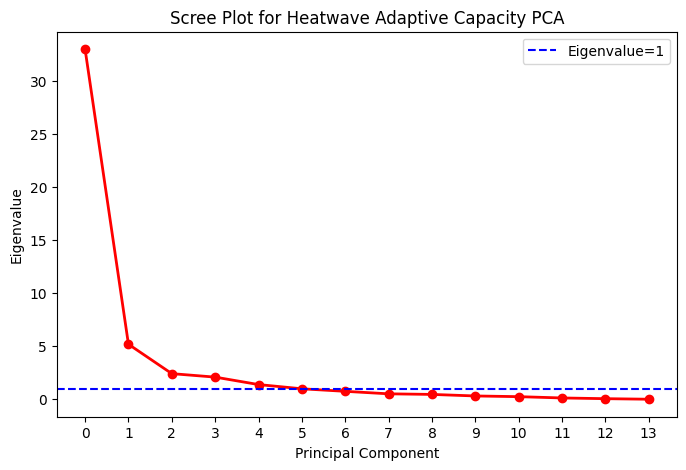

In [10]:
import matplotlib.pyplot as plt

eigenvalues = pca.explained_variance_
xvals = np.arange(len(eigenvalues))

plt.figure(figsize=(8,5))
plt.plot(xvals, eigenvalues, 'ro-', linewidth=2)
plt.title("Scree Plot for Heatwave Adaptive Capacity PCA")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue")
plt.axhline(y=1, color='b', linestyle='--', label="Eigenvalue=1")
plt.xticks(xvals)
plt.legend()
plt.show()


In [ ]:
loadings_heat = pd.DataFrame(
    pca_n.components_.T,
    index=acap_pca_vars,
    columns=[f"PC{i+1}" for i in range(n_components)]
)
print(loadings_heat)


In [11]:
n_components = 5
pca_n = PCA(n_components=n_components)
X_acap_pca = pca_n.fit_transform(X_acap)

# Extract the top PC variance ratios
pca_weights = pcaSummary_heat['% variance'][:n_components]

# Save PC scores in the DataFrame
for i in range(n_components):
    heatwave_acap_df[f"HeatAdapt_PC{i+1}"] = X_acap_pca[:, i]

# Weighted sum => "Heatwave_AdaptiveCap_Index"
heatwave_acap_df["Heatwave_AdaptiveCap_Index"] = 0
for i in range(n_components):
    heatwave_acap_df["Heatwave_AdaptiveCap_Index"] += (
        pca_weights.iloc[i] * heatwave_acap_df[f"HeatAdapt_PC{i+1}"]
    )

print(heatwave_acap_df[["block_code", "Heatwave_AdaptiveCap_Index"]].head())
print(heatwave_acap_df["Heatwave_AdaptiveCap_Index"].describe())


   block_code  Heatwave_AdaptiveCap_Index
0        6498                   -0.089144
1        6492                   -1.007412
2        4689                    2.583778
3        4690                   -0.708831
4        4692                   -0.414446
count    5.815000e+03
mean     5.376420e-17
std      4.003821e+00
min     -1.608057e+00
25%     -8.024224e-01
50%     -5.022792e-01
75%     -2.427178e-02
max      1.934649e+02
Name: Heatwave_AdaptiveCap_Index, dtype: float64
